In [1]:
import pandas as pd
import numpy as np
from resqu import data, plotter, make_dataset as md, get_last_sub_ver

from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import KFold

pd.set_option("display.max_columns", None)

In [2]:
ver = "v0_wind"
in_dir_train = data.data_dir / f"flights_train_preproc_{ver}"
in_dir_rank = data.data_dir / f"flights_rank_preproc_{ver}"
in_dir_final = data.data_dir / f"flights_final_preproc_{ver}"

agg_funcs = ["mean", "std", "min", "max"]
split_funcs = ["mean", "std"]
split_feat = ["vertical_rate"]
# split_feat = 'all'
split = 9

# split_feat = None
# split = 0

df_train = md.make_lgbm_dataset(
    in_dir=in_dir_train,
    flight_set=data.FlightSet.TRAIN,
    agg_funcs=agg_funcs,
    split_funcs=split_funcs,
    split_feat=split_feat,
    split=split,
)
df_rank = md.make_lgbm_dataset(
    in_dir=in_dir_rank,
    flight_set=data.FlightSet.RANK,
    agg_funcs=agg_funcs,
    split_funcs=split_funcs,
    split_feat=split_feat,
    split=split,
)

df_final = md.make_lgbm_dataset(
    in_dir=in_dir_final,
    flight_set=data.FlightSet.FINAL,
    agg_funcs=agg_funcs,
    split_funcs=split_funcs,
    split_feat=split_feat,
    split=split,
)

# df_train.to_parquet(data.lgbm_data_dir / "df_train.parquet")
# df_rank.to_parquet(data.lgbm_data_dir / "df_rank.parquet")
# df_final.to_parquet(data.lgbm_data_dir / "df_final.parquet")

Processing flights:   0%|          | 0/11037 [00:00<?, ?it/s]

Processing flights:   0%|          | 0/11037 [00:00<?, ?it/s]

Processing flights:   0%|          | 0/1888 [00:00<?, ?it/s]

Processing flights:   0%|          | 0/1888 [00:00<?, ?it/s]

Processing flights:   0%|          | 0/2836 [00:00<?, ?it/s]

Processing flights:   0%|          | 0/2836 [00:00<?, ?it/s]

In [3]:
df_train.to_parquet(data.lgbm_data_dir / "df_train_v0_wind.parquet")
df_rank.to_parquet(data.lgbm_data_dir / "df_rank_v0_wind.parquet")
df_final.to_parquet(data.lgbm_data_dir / "df_final_v0_wind.parquet")

In [4]:
# df_train.isna().sum()
# df_train[(df_train.tau_s >= 0) & (df_train.tau_e <= 1)].isna().sum()
nan_mask = df_train.seg_dist.isna()
df_train_nan = df_train[nan_mask]
nan_fids = df_train_nan.flight_id.unique()
len(nan_fids)

1179

In [6]:
ct_features = [
    "aircraft_type",
    "phase",
]
df_train[ct_features] = df_train[ct_features].astype("category")
df_rank[ct_features] = df_rank[ct_features].astype("category")

df_features_train = df_train[
    (df_train["ff_kgs"] < 6.5) & (df_train["ff_kgs"] > 0.05) #& ~nan_mask
    # & (df_train.tau_s >= 0) & (df_train.tau_e <= 1)
]
# df_features_train = df_train

len(df_features_train), len(df_train)

(131016, 131530)

In [7]:
(df_train.flight_date < pd.to_datetime("2025-08-01").date()).sum() / len(df_train)

np.float64(0.9250893332319623)

In [8]:
pred_col = "ff_kgs"
# target_col = "ff_res"
categorical_features = ["aircraft_type", "phase"]

# ======================
# Train / Test prep
# ======================
# Train on ALL of df_features_train
# Columns to drop explicitly
drop_target_columns = [
    "idx",
    "start",
    "end",
    "takeoff",
    "landed",
    "flight_date",
    "flight_duration",
    "ts",
    # "aircraft_type",
    "flight_id",
    "cumdist",
    "distance_km",
    "latitude",
    "longitude",
    # "CAS",
    # "mach",
    # "track",
    # "ts",
    "fuel_kg",
    # "ff_kgs",
]

drop_minmax_columns = [
    col
    for col in df_features_train.columns
    if (col.endswith("_min") or col.endswith("_max"))
    and not col.startswith("vertical_rate")
]
drop_actual_columns = [
    col
    for col in df_features_train.columns
    if any(col.startswith(f"{base}") for base in drop_target_columns)
]
drop_actual_columns.append(pred_col)
drop_actual_columns.extend(drop_minmax_columns)

drop_extra = ["altitude_std", "track_std", "tau_s", "tau_e"]

drop_actual_columns.extend(drop_extra)

X = df_features_train.drop(columns=drop_actual_columns, errors="ignore")
y = df_features_train[pred_col]

train_columns = X.columns
cat_feats_actual = [c for c in categorical_features if c in train_columns]
cat_feats_actual

['aircraft_type', 'phase']

In [9]:
X.columns, len(X.columns)

(Index(['seg_duration', 'aircraft_type', 'tow_est_kg', 'full_flight_dist',
        'seg_dist', 'phase', 'altitude_mean', 'groundspeed_mean',
        'groundspeed_std', 'track_mean', 'vertical_rate_mean',
        'vertical_rate_std', 'vertical_rate_min', 'vertical_rate_max',
        'mach_mean', 'mach_std', 'TAS_mean', 'TAS_std', 'CAS_mean', 'CAS_std',
        'ff_kgs_est_mean', 'ff_kgs_est_std', 'mass_est_mean', 'mass_est_std',
        'm_tow', 'oew', 'vertical_rate_mean_0', 'vertical_rate_mean_1',
        'vertical_rate_mean_2', 'vertical_rate_mean_3', 'vertical_rate_mean_4',
        'vertical_rate_mean_5', 'vertical_rate_mean_6', 'vertical_rate_mean_7',
        'vertical_rate_mean_8', 'vertical_rate_mean_9', 'vertical_rate_std_0',
        'vertical_rate_std_1', 'vertical_rate_std_2', 'vertical_rate_std_3',
        'vertical_rate_std_4', 'vertical_rate_std_5', 'vertical_rate_std_6',
        'vertical_rate_std_7', 'vertical_rate_std_8', 'vertical_rate_std_9'],
       dtype='object'),
 

In [37]:
base_params = {
    "n_estimators": 7500,
    "learning_rate": 0.01,
    "subsample": 0.8,  # row subsampling
    # "subsample_freq": 1,
    "colsample_bytree": 0.5,  # feature subsampling
    "reg_lambda": 0.5,
    # "reg_alpha": 0.1,
    "metric": "rmse",
    # "verbose": -1,
    # "num_iterations": 5000,
    "early_stopping_round": 50,
    "device": "gpu",
}

# seed = 42

# params = {
#     **base_params,
#     "random_state": seed,
#     "bagging_seed": seed,
#     "feature_fraction_seed": seed,
# }
X_, X_test, y_, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    shuffle=False,
    # random_state=seed,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_,
    y_,
    test_size=0.15,
    shuffle=False,
)

# model = LGBMRegressor(**params)
model = LGBMRegressor(**base_params)
model.fit(
    X_train,
    y_train,
    # X,
    # y,
    eval_set=[(X_val, y_val)],
    categorical_feature=cat_feats_actual,
)

train_pred = model.predict(X_train)
rmse_train = rmse(
    y_train * X_train["seg_duration"], train_pred * X_train["seg_duration"]
)
test_pred = model.predict(X_test)
rmse_test = rmse(y_test * X_test["seg_duration"], test_pred * X_test["seg_duration"])
# rmse_train = rmse((y_test.fillna(0) + X_test.ff_kgs_est.fillna(0))*X_test['deltat'], (train_pred + X_test.ff_kgs_est.fillna(0))*X_test['deltat'])

print(f"Train RMSE: {rmse_train:.5f}")
print(f"Test RMSE: {rmse_test:.5f}")
print(f"R^2 {model.score(X_test, y_test)}")

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5596
[LightGBM] [Info] Number of data points in the train set: 92550, number of used features: 26
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (2.47 MB) transferred to GPU in 0.002050 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.962057
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1039]	valid_0's rmse: 0.283854
Train RMSE: 174.25940
Test RMSE: 144.62079
R^2 0.8174098988419043


<Axes: title={'center': 'Prediction Historgram: train fuel kg\nRMSE: 174.259405\nR2: 0.963608'}, xlabel='Predicted', ylabel='Real'>

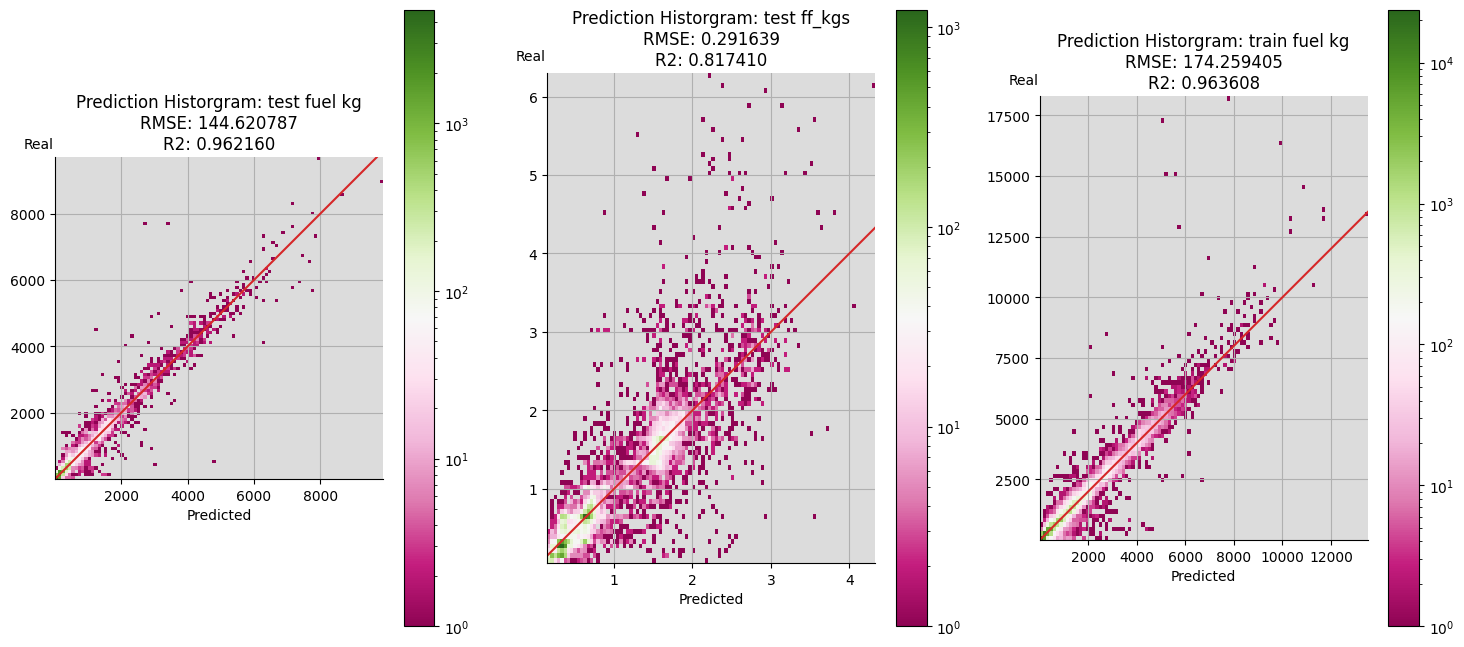

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 8))
axs = fig.subplots(1, 3)
plotter.plot_pred_result(
    test_pred * X_test.seg_duration,
    y_test.values * X_test.seg_duration,
    ax=axs[0],
    desc="test fuel kg",
)
plotter.plot_pred_result(test_pred, y_test, ax=axs[1], desc="test ff_kgs")

plotter.plot_pred_result(
    train_pred * X_train.seg_duration,
    y_train.values * X_train.seg_duration,
    ax=axs[2],
    desc="train fuel kg",
)

In [23]:
base_params = {
    "n_estimators": 7500,
    "learning_rate": 0.01,
    "subsample": 0.8,  # row subsampling
    "colsample_bytree": 0.8,  # feature subsampling
    "reg_lambda": 0.5,
    "reg_alpha": 0.1,
    "metric": "rmse",
    # "verbose": -1,
    # "n_jobs": 12,
    # "num_iterations": 5000,
    # "early_stopping_round": 100,
    "device": "gpu",
}
# model = LGBMRegressor(**params)
model_sub = LGBMRegressor(**base_params)
model_sub.fit(
    # X_,
    # y_,
    X,
    y,
    eval_set=[(X, y)],
    categorical_feature=cat_feats_actual,
)

train_pred = model_sub.predict(X_)
rmse_train = rmse(y_ * X_["seg_duration"], train_pred * X_["seg_duration"])
val_pred = model_sub.predict(X_test)
rmse_val = rmse(y_test * X_test["seg_duration"], val_pred * X_test["seg_duration"])
# rmse_train = rmse((y_test.fillna(0) + X_test.ff_kgs_est.fillna(0))*X_test['deltat'], (train_pred + X_test.ff_kgs_est.fillna(0))*X_test['deltat'])

print(f"Train RMSE: {rmse_train:.5f}")
print(f"Test RMSE: {rmse_val:.5f}")
print(f"R^2 {model_sub.score(X_test, y_test)}")

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5620
[LightGBM] [Info] Number of data points in the train set: 128098, number of used features: 26
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 25 dense feature groups (3.42 MB) transferred to GPU in 0.003078 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.925234
Train RMSE: 131.95330
Test RMSE: 90.72197
R^2 0.9251636367004867


<Axes: title={'center': 'Prediction Historgram: train fuel kg\nRMSE: 131.953301\nR2: 0.978216'}, xlabel='Predicted', ylabel='Real'>

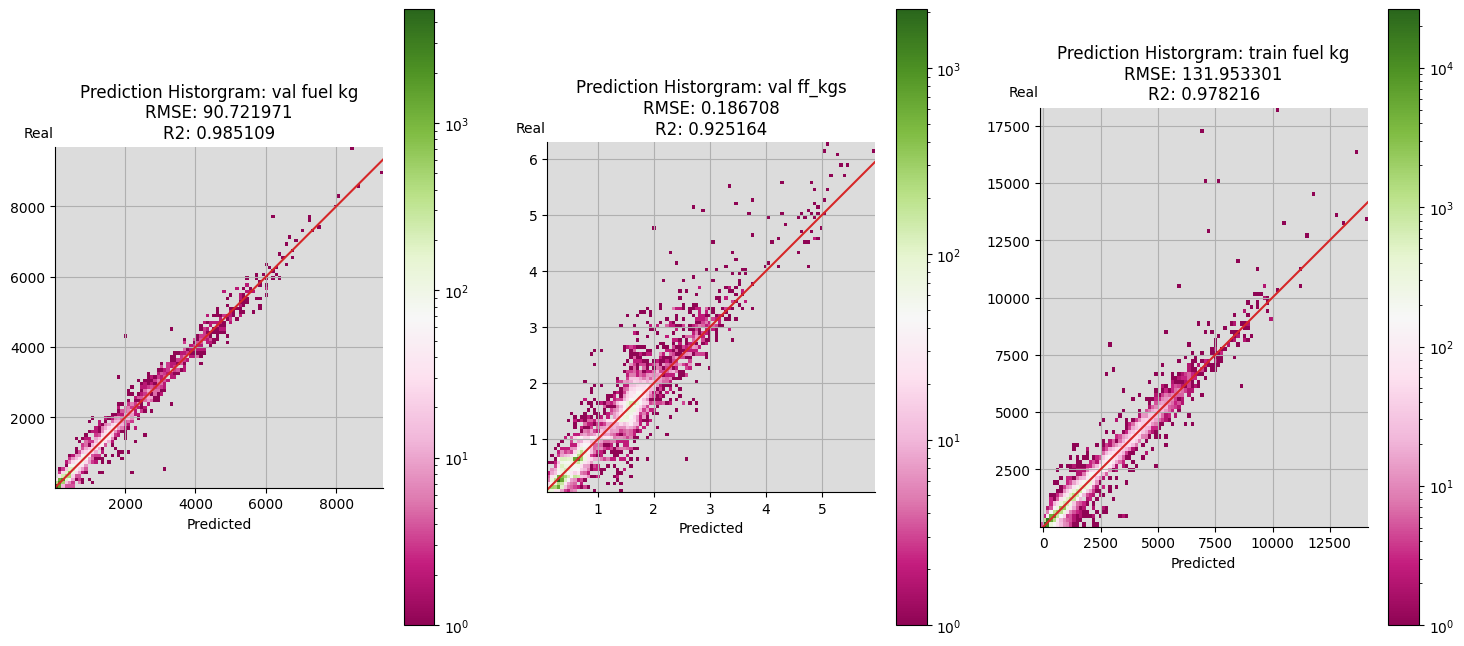

In [24]:
fig = plt.figure(figsize=(18, 8))
axs = fig.subplots(1, 3)
plotter.plot_pred_result(
    val_pred * X_test.seg_duration,
    y_test.values * X_test.seg_duration,
    ax=axs[0],
    desc="val fuel kg",
)
plotter.plot_pred_result(val_pred, y_test, ax=axs[1], desc="val ff_kgs")

plotter.plot_pred_result(
    train_pred * X_.seg_duration,
    y_.values * X_.seg_duration,
    ax=axs[2],
    desc="train fuel kg",
)

In [25]:
# Build X_rank from rank; drop leak cols, keep features only
df_features_rank = df_rank
X_rank = df_features_rank.drop(columns=drop_actual_columns, errors="ignore").copy()

# Ensure 'seg_duration' exists for final kg computation
if "seg_duration" not in df_features_rank.columns:
    raise ValueError(
        "'seg_duration' must exist in df_features_rank for fuel_kg computation."
    )

# Align columns: X_rank must have EXACTLY the training columns in the same order
train_columns = list(X.columns)

# Drop any extra columns in test not seen in training
extra_test_cols = [c for c in X_rank.columns if c not in train_columns]
if extra_test_cols:
    X_rank = X_rank.drop(columns=extra_test_cols)

# Add any missing columns in rank (should be rare), fill with NaN
for c in train_columns:
    if c not in X_rank.columns:
        X_rank[c] = np.nan

X_rank = X_rank[train_columns]

In [26]:
# ======================
# Output
# ======================
rank_pred = model.predict(X_rank)
df_features_rank["ff_kgs"] = rank_pred
df_features_rank["fuel_kg"] = rank_pred * df_features_rank["seg_duration"].values

In [27]:
# %%
last_ver = get_last_sub_ver()
df_fuel_submission_final = pd.read_parquet(
    data.data_dir / "fuel_rank_submission.parquet"
)

df_fuel_submission_final["fuel_kg"] = df_features_rank["fuel_kg"].values

# Save result
df_fuel_submission_final.to_parquet(
    data.data_dir / f"submission/resourceful-quiver_v{last_ver + 1}.parquet",
    index=False,
)

print(
    f"✅ Added fuel_kg to df_fuel_submission_final — new shape: {df_fuel_submission_final.shape}"
)
print(df_fuel_submission_final[["idx", "fuel_kg"]].head())

last version: 162
✅ Added fuel_kg to df_fuel_submission_final — new shape: (24289, 5)
   idx     fuel_kg
0    0  187.357278
1    1  192.693908
2    2  193.892977
3    3  192.575981
4    4  192.988841
